In [48]:
import sys
import os
import numpy as np
import time
# Add the parent folder to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import density_generator
import numpy as np
import matplotlib.pyplot as plt
import qutip
import importlib
import helper_functions
import classicalQFI
import quantum_subroutines_pennylane
import pipeline_v200
import vqfe_subroutine
import pennylane as qml
import circuit_generator
from scipy.linalg import eigh
#from pennylane import numpy as np

from random import randint
importlib.reload(density_generator)
importlib.reload(helper_functions)
importlib.reload(quantum_subroutines_pennylane)
importlib.reload(vqfe_subroutine)
importlib.reload(pipeline_v200)
importlib.reload(circuit_generator)
importlib.reload(classicalQFI)

pass;

In [3]:
## parameters
N=5
n=3
#trace_out_indices= list(range(N - n))
trace_out_indices = np.sort(np.random.choice(range(N), size= N - n, replace=False))
#trace_out_indices = [0]
J=1
h_z=0.1
delta=0.5
m=1
# initial_state=None
DEBUG=False
derivative_delta=1e-3

print("N =",N, " starting number of qubits, before tracing out")
print("n =",n," final number of qubits")
print("trace_out_indices =",trace_out_indices)
print("J =",J)
print("h_z =",h_z)
print("delta =",delta)
print("m =",m)
print("DEBUG is set to: ",DEBUG)

N = 5  starting number of qubits, before tracing out
n = 3  final number of qubits
trace_out_indices = [2 4]
J = 1
h_z = 0.1
delta = 0.5
m = 1
DEBUG is set to:  False


In [4]:
trace_out_indices

array([2, 4])

In [5]:
# classical
print("TEST 1 : classical\n")
model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
## using N because i will trace out

rho_pure, rho_delta_pure = model.generate_density_matrices_with_perturbation(delta=delta)
print("rho_pure shape = ", rho_pure.shape)
evals = np.linalg.eigvalsh(rho_pure)
entropy = -np.sum(evals * np.log2(evals + 1e-12))  # small epsilon for numerical stability
print("entanglement entropy = ", entropy)


rho_mixed, rho_delta_mixed = model.generate_mixed_density_matrices_with_perturbation(delta=delta,trace_out_indices=trace_out_indices)
print("rho_mixed shape = ", rho_mixed.shape)
print("purity of rho", np.trace(rho_mixed @ rho_mixed))
print("purity of rho_delta", np.trace(rho_delta_mixed @ rho_delta_mixed))

evals = np.linalg.eigvalsh(rho_mixed)
entropy = -np.sum(evals * np.log2(evals + 1e-12))  # small epsilon for numerical stability
print("entanglement entropy = ", entropy)

print("uhlmann fidelity = ", helper_functions.uhlmann_fidelity_root(rho_mixed, rho_delta_mixed))
print("fidelity pennylane = ",helper_functions.fidelity_pennylane(rho_mixed, rho_delta_mixed))


TEST 1 : classical

rho_pure shape =  (32, 32)
entanglement entropy =  -1.4469168956837894e-12
rho_mixed shape =  (8, 8)
purity of rho (0.33360699733510757+0j)
purity of rho_delta (0.3782220417089385+0j)
entanglement entropy =  1.7494297088771567
uhlmann fidelity =  0.8398174427249401
fidelity pennylane =  0.7052933526378928


TEST 2 : quantum

(<Figure size 3200x1100 with 1 Axes>, <Axes: >)


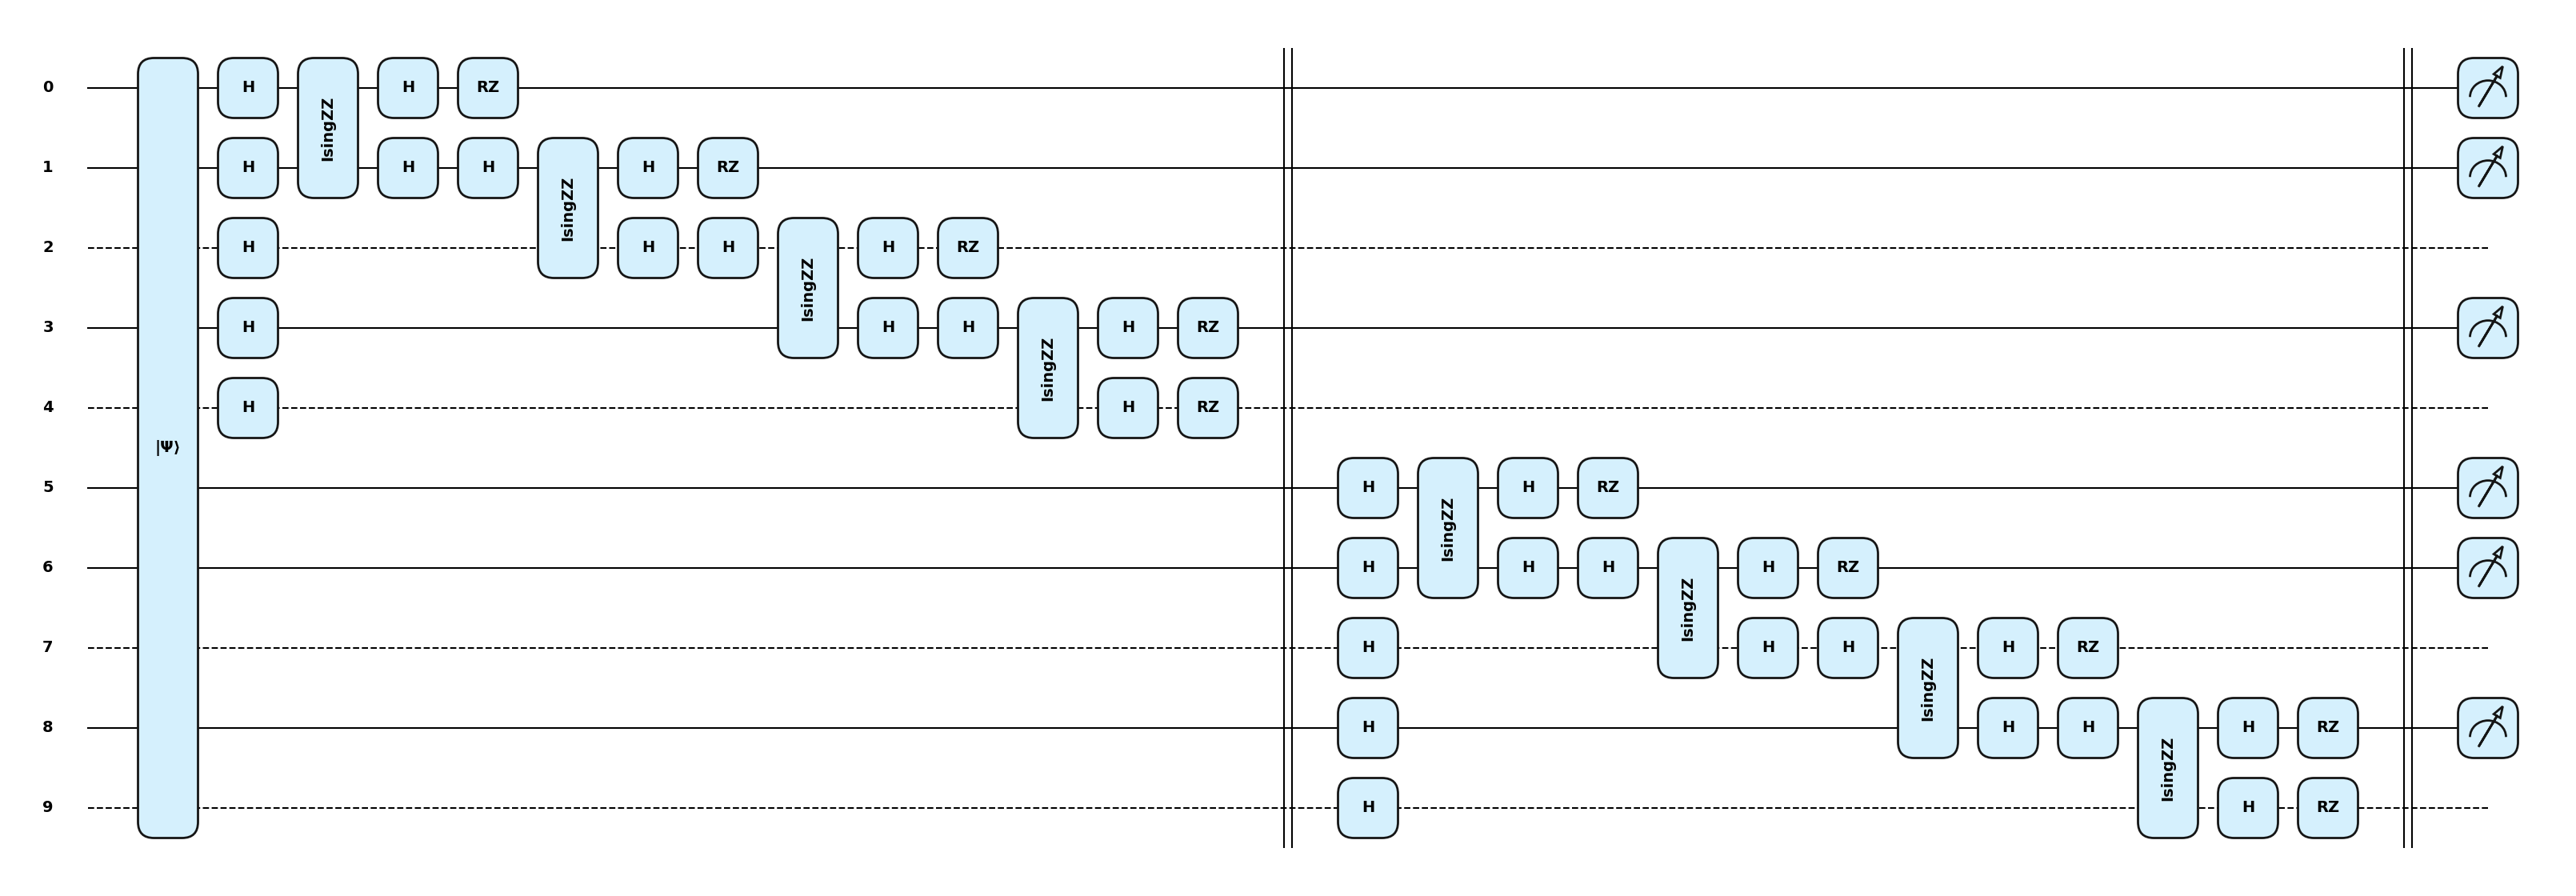

In [6]:
print("TEST 2 : quantum\n")

DRAW = True

import pennylane as qml
import pennylane.numpy as np

circuit_fn = circuit_generator.make_xx_plus_z_circuits(J, h_z, delta, N) 

# Attach to a device and QNode
dev = qml.device("default.qubit", wires=2 * N)

# trace out for the whole system composed by sys 1 and sys 2

active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]


@qml.qnode(dev)
def qnode():
    circuit_fn()
    #return qml.state()
    return qml.density_matrix(wires=measured_wires)


# --- Print the Circuit ---
wire_options = {
    #i: {'color': 'teal', 'linestyle': '--'} for i in discaded_wires # discarded wires
    i: {'linestyle': '--'} for i in discarded_wires # discarded wires
}

if DRAW:
    # Draw the circuit
    drawer = qml.draw_mpl(qnode, style="pennylane", wire_options=wire_options)
    #drawer = qml.draw(qnode)
    print(drawer())
 

In [7]:
vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
    circuit_fn = circuit_fn,
    total_num_qubits=2*N,
    active_rho_wires = active_rho, 
    active_rho_delta_wires = active_rho_delta,
    L=2, 
    m=1, 
    maxiter=200)
vqfe_results


{'F_trunc': tensor(0.41896007, requires_grad=True),
 'F_star': tensor(0.99933645, requires_grad=True),
 'top_eigenvalues_rho': tensor([0.43731829], requires_grad=True),
 'trace_rho_m': tensor(0.43731829, requires_grad=True),
 'trace_sigma_m': 0.4013725151327401,
 'opt_params': array([[[ 1.13106572,  0.00774839,  0.03980618],
         [-0.08921295, -0.00147421, -0.09652301],
         [ 0.88813861, -0.02423396,  1.42501292]],
 
        [[ 0.23771894,  1.144695  , -0.01461141],
         [-0.49912386,  0.42317355,  0.07377421],
         [ 0.10689131, -0.01311384,  0.13378117]]]),
 'rho_rotated_final': array([[ 1.00980811e-04-2.39835816e-18j,  4.81204314e-06-1.12719300e-05j,
          1.51476058e-06+2.20409205e-06j,  4.98488538e-06-1.99759284e-05j,
         -1.66939770e-03+8.48901416e-04j, -1.25881349e-03-1.93169762e-04j,
          1.09219969e-04-8.72943325e-05j, -6.91454021e-05-4.27746653e-03j],
        [ 4.81204314e-06+1.12719300e-05j,  6.10264705e-05-4.67941058e-18j,
          2.27580206

In [55]:
# collect fidelities

## parameters
N=4
n=3
trace_out_indices = np.random.choice(range(N), size= N - n, replace=False)
J=1
delta=0.5
m=2
# initial_state=None
DEBUG=False
derivative_delta=1e-3


# indices for quantum part
# trace out for the whole system composed by sys 1 and sys 2
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]



results = []

for h_z in np.linspace(0, 2.5, 20):

    # classical fidelity
    # classical

    model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
    
    rho_mixed, rho_delta_mixed = model.generate_mixed_density_matrices_with_perturbation(delta=delta,trace_out_indices=trace_out_indices)

    classical_results = classicalQFI.compute_tqfi_bounds(rho_mixed, rho_delta_mixed, m, delta, DEBUG=False)
    
    # quantum fidelity

    circuit_fn = circuit_generator.make_xx_plus_z_circuits(J, h_z, delta, N) 

    # Attach to a device and QNode
    dev = qml.device("default.qubit", wires=2 * N)
    vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
        circuit_fn = circuit_fn,
        total_num_qubits=2*N,
        active_rho_wires = active_rho, 
        active_rho_delta_wires = active_rho_delta,
        L=2, 
        m=m, 
        maxiter= 256)

    results.append({
        "hz": h_z,
        "(Classical) uhlmann_fidelity": classical_results["uhlmann_fidelity"],
        "(Classical) pennylane_fidelity": classical_results["fidelity_pennylane"],
        "(Classical) fidelity_truncated":classical_results["fidelity_truncated"],
        "(Classical) fidelity_truncated_generalized": classical_results["fidelity_truncated_generalized"],
        #"(Classical) Participation Ratio" : classical_results["F_trunc"],
        "(Quantum) F_trunc" : vqfe_results["F_trunc"].item(),
        "(Quantum) F_star" : vqfe_results["F_star"].item(),

    })

    # quantum fidelity
    

df = pd.DataFrame(results)

    

/home/ronin/miniforge3/envs/space/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ronin/miniforge3/envs/space/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


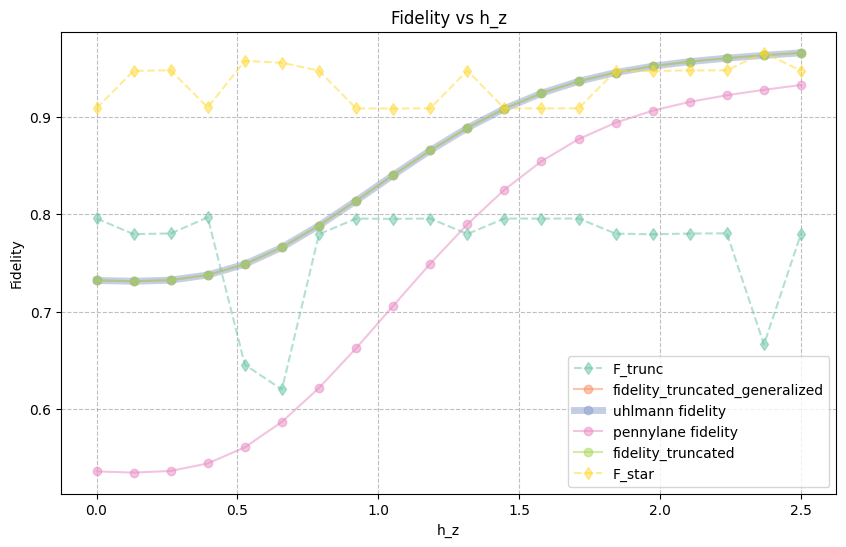

In [56]:
# plot fidelities
import seaborn as sns
sns.set_palette("Set2")
plt.figure(figsize=(10, 6))
plt.plot(df["hz"], df["(Quantum) F_trunc"], label="F_trunc", marker='d', linestyle='--', alpha=0.5)
plt.plot(df["hz"], df["(Classical) fidelity_truncated_generalized"], label="fidelity_truncated_generalized", marker='o', alpha=0.5)
plt.plot(df["hz"], df["(Classical) uhlmann_fidelity"], label="uhlmann fidelity", marker='o', linewidth=5, alpha=0.5)
plt.plot(df["hz"], df["(Classical) pennylane_fidelity"], label="pennylane fidelity", marker='o', alpha=0.5)
plt.plot(df["hz"], df["(Classical) fidelity_truncated"], label="fidelity_truncated", marker='o', alpha=0.5)
plt.plot(df["hz"], df["(Quantum) F_star"], label="F_star", marker='d', linestyle='--', alpha=0.5)
plt.xlabel("h_z")
plt.ylabel("Fidelity")
plt.title("Fidelity vs h_z")
plt.legend()
# use a discomtinuous line style grid
plt.grid(
    linestyle='--',
    color='gray',
    alpha=0.5
)
plt.show()

In [10]:
uhlmann_fidelity = df["(Classical) uhlmann_fidelity"].values
uhlmann_fidelity

array([0.73195257, 0.7311377 , 0.7322808 , 0.73755258, 0.74865686,
       0.76595599, 0.78834086, 0.81380086, 0.84015555, 0.86555002,
       0.8886084 , 0.90837373, 0.92433495, 0.93655104, 0.94555049,
       0.95205583, 0.95677994, 0.96034065, 0.96323332, 0.96581945])

In [ ]:
# compare states

## parameters
N=3
n=2
trace_out_indices = np.random.choice(range(N), size= N - n, replace=False)
J=1
delta=0.5
m=1
# initial_state=None
DEBUG=False
derivative_delta=1e-3


# indices for quantum part
# trace out for the whole system composed by sys 1 and sys 2
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]
h_z = 0.1


results = []


# classical fidelity
# classical

model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 

rho_mixed, rho_delta_mixed = model.generate_mixed_density_matrices_with_perturbation(delta=delta,trace_out_indices=trace_out_indices)

print(f"purity of rho_mixed: {np.trace(rho_mixed @ rho_mixed)}")
print(f"partcipation ratio of rho_mixed: {1/ np.trace(rho_mixed @ rho_mixed)}")

qobj_1 = helper_functions.dm_to_qobj(rho_mixed, title="rho_mixed")

classical_results = classicalQFI.compute_tqfi_bounds(rho_mixed, rho_delta_mixed, m, delta, DEBUG=False)

# quantum fidelity

circuit_fn = circuit_generator.make_xx_plus_z_circuits(J, h_z, delta, N) 
q_dm = circuit_generator.get_density_matrix_circuit(circuit_factory=circuit_fn,
                                                    active_qubits=active_rho)
# Load a device
dev = qml.device("default.qubit", wires=2 * N)

# Create the QNode for the density matrix circuit
density_matrix_qnode = qml.QNode(q_dm, dev)

# Execute the QNode to get the density matrix
quantum_density_matrix = density_matrix_qnode()
qobj_2 = helper_functions.dm_to_qobj(quantum_density_matrix, title="quantum_density_matrix")

print(f"Density matrix of qubits {active_rho}:\n")


# Attach to a device and QNode
dev = qml.device("default.qubit", wires=2 * N)
vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
    circuit_fn = circuit_fn,
    total_num_qubits=2*N,
    active_rho_wires = active_rho, 
    active_rho_delta_wires = active_rho_delta,
    L=2, 
    m=m, 
    maxiter= 256)

results.append({
    "hz": h_z,
    "(Classical) uhlmann_fidelity": classical_results["uhlmann_fidelity"],
    "(Classical) pennylane_fidelity": classical_results["fidelity_pennylane"],
    "(Classical) fidelity_truncated":classical_results["fidelity_truncated"],
    "(Classical) fidelity_truncated_generalized": classical_results["fidelity_truncated_generalized"],
    "(Quantum) F_trunc" : vqfe_results["F_trunc"].item(),
    "(Quantum) F_star" : vqfe_results["F_star"].item(),

})

# quantum fidelity
df = pd.DataFrame(results)


purity of rho_mixed: (0.5807337467785696+0j)
partcipation ratio of rho_mixed: (1.7219595133693757+0j)
Density matrix of qubits [1, 2]:



In [ ]:
qobj_1


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.0947817 +0.j         0.        +0.j         0.        +0.j
  0.05320086+0.12858411j]
 [0.        +0.j         0.49661188+0.j         0.03732097-0.31633297j
  0.        +0.j        ]
 [0.        +0.j         0.03732097+0.31633297j 0.20430321+0.j
  0.        +0.j        ]
 [0.05320086-0.12858411j 0.        +0.j         0.        +0.j
  0.20430321+0.j        ]]

In [53]:
qobj_2

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 8.52211291e-02+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          5.16851775e-02+0.12224694j]
 [ 0.00000000e+00+0.j          5.01367966e-01+0.j
  -1.99493200e-17-0.32192467j  0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j         -1.99493200e-17+0.32192467j
   2.06705453e-01+0.j          0.00000000e+00+0.j        ]
 [ 5.16851775e-02-0.12224694j  0.00000000e+00+0.j
   0.00000000e+00+0.j          2.06705453e-01+0.j        ]]